In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1.

Draw $n = 300$ real numbers uniformly at random on $[0,1]$, call them $x_1,\dots,x_n$

# 

In [2]:
seed = 1234
rng = np.random.default_rng(seed)

n = 300
x = rng.uniform(0, 1, n)
x[:10]

array([0.97669977, 0.38019574, 0.92324623, 0.26169242, 0.31909706,
       0.11809123, 0.24176629, 0.31853393, 0.96407925, 0.2636498 ])

# 2.

Draw $n$ real numbers uniformly at random on $[-\frac{1}{10}, \frac{1}{10}]$, call them $\nu_1,\dots,\nu_n$

In [3]:
nu = rng.uniform(-0.1, 0.1, n)
nu[:10]

array([ 0.01448261, -0.00179627,  0.04393777, -0.00724272,  0.07022269,
        0.05766653,  0.00820945,  0.08925706,  0.0292772 , -0.01571918])

# 3.

Let $d_i = \sin(20 x_i) + 3 x_i + \nu_i$, $i = 1,\dots,n$. Plot the points $(x_i, d_i)$, $i = 1,\dots,n$.


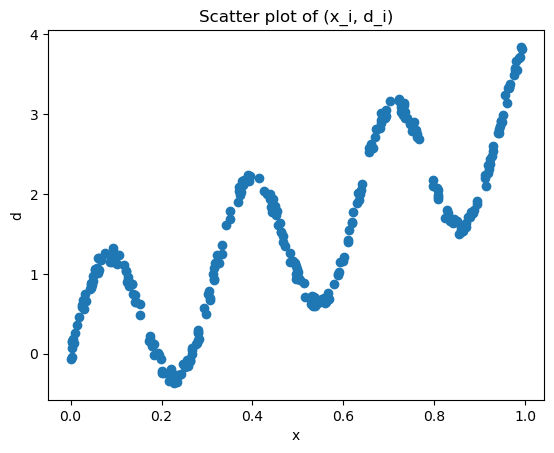

In [4]:
d = np.sin(20 * x) + 3 * x + nu

plt.scatter(x, d)
plt.xlabel('x')
plt.ylabel('d')
plt.title('Scatter plot of (x_i, d_i)')

plt.show()


We will consider a $1 \times N \times 1$ neural network with one input, $N = 24$ hidden neurons, and $1$ output neuron. The network will thus have $3N + 1$ weights including biases. Let $\mathbf{w}$ denote the vector of all these $3N + 1$ weights. The output neuron will use the activation function $\phi(v) = v$; all other neurons will use the activation function $\phi(v) = \tanh(v)$. Given input $x$, we use the notation $f(x, \mathbf{w})$ to represent the network output.

# 4.

Use the backpropagation algorithm with online learning to find the optimal weights/network that minimize the mean-squared error (MSE) $\frac{1}{n} \sum_{i=1}^n (d_i - f(x_i, \mathbf{w}))^2$. Use some $\eta$ of your choice. Plot the number of epochs vs the MSE in the backpropagation algorithm. 

Hint: Since this is a very simple network, you can just manually derive the derivatives if you like without using the BP algorithm.

Hint: As discussed in class, for a given fixed $\eta$, the algorithm may not always results in a monotonically decreasing MSE (the descent may overshoot the locally optimal point). You may have to modify the gradient descent algorithm in such a way that you decrease $\eta$ (e.g. via $\eta \leftarrow 0.9\eta$) whenever you detect that the MSE has increased. Also, beginning with a very large $\eta$ may result in an immediate divergence of the weights.

In [5]:
class NeuralNetwork:
    def __init__(self, rng, learning_rate=0.01):
        self.hidden_size = 24
        self.learning_rate = learning_rate

        # Initialize parameters
        self.hidden_weights = rng.standard_normal(self.hidden_size)
        self.hidden_biases = rng.standard_normal(self.hidden_size)
        self.output_weights = rng.standard_normal(self.hidden_size)
        self.output_bias = rng.standard_normal(1)
        
    def forward_all(self, X):
        """Forward pass for all samples."""
        self.hidden_field = X[:, np.newaxis] * self.hidden_weights + self.hidden_biases
        self.hidden_output = np.tanh(self.hidden_field)
        self.output = np.dot(self.hidden_output, self.output_weights) + self.output_bias
        return self.output.flatten()

    def forward_single(self, x):
        """Forward pass for a single sample."""
        self.hidden_field = x * self.hidden_weights + self.hidden_biases
        self.hidden_output = np.tanh(self.hidden_field)
        self.output = np.dot(self.hidden_output, self.output_weights) + self.output_bias
        return self.output

    def backprop(self, x, d):
        """One-sample online backpropagation update."""
        y = self.forward_single(x)
        error = d - y

        # Gradients
        tanh_derivative = 1 - np.tanh(self.hidden_field) ** 2
        dE_dhidden_weights = error * self.output_weights.T * tanh_derivative * x
        dE_dhidden_biases = error * self.output_weights.T * tanh_derivative
        dE_doutput_weights = error * self.hidden_output
        dE_doutput_bias = error
        

        # Weight updates
        self.hidden_weights += self.learning_rate * dE_dhidden_weights
        self.hidden_biases += self.learning_rate * dE_dhidden_biases
        self.output_weights += self.learning_rate * dE_doutput_weights
        self.output_bias += self.learning_rate * dE_doutput_bias
    
        return float(error ** 2)

    def gradient_descent(self, X, D, mse_threshold=1e-6, epoch_limit=10000):
        """Train with online gradient descent."""
        mse_history = []
        
        mse = float('inf')
        epoch = 0
        while mse > mse_threshold and epoch < epoch_limit:
            mse = 0
            for x, d in zip(X, D):
                mse += self.backprop(np.array([x]), np.array([d]))
            mse /= len(X)

            # Adaptive learning rate
            if epoch > 0 and mse >= mse_history[-1]:
                    self.learning_rate *= 0.9
            
            # Logging    
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch+1} - MSE: {mse:.6f} - LR: {self.learning_rate:.5f}")
            
            epoch += 1
            mse_history.append(mse)


        return mse_history


In [6]:
# Initialize and train network
nn = NeuralNetwork(rng, learning_rate=0.01)
mse_history = nn.gradient_descent(x, d, mse_threshold=1e-6, epoch_limit=10000)


/tmp/ipykernel_10407/3604997113.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(error ** 2)


Epoch 100 - MSE: 0.493559 - LR: 0.01000
Epoch 200 - MSE: 0.484553 - LR: 0.01000
Epoch 300 - MSE: 0.477938 - LR: 0.01000
Epoch 400 - MSE: 0.471122 - LR: 0.01000
Epoch 500 - MSE: 0.463985 - LR: 0.01000
Epoch 600 - MSE: 0.455353 - LR: 0.01000
Epoch 700 - MSE: 0.444457 - LR: 0.01000
Epoch 800 - MSE: 0.430286 - LR: 0.01000
Epoch 900 - MSE: 0.409943 - LR: 0.01000
Epoch 1000 - MSE: 0.381964 - LR: 0.01000
Epoch 1100 - MSE: 0.348705 - LR: 0.01000
Epoch 1200 - MSE: 0.318185 - LR: 0.01000
Epoch 1300 - MSE: 0.297594 - LR: 0.01000
Epoch 1400 - MSE: 0.286172 - LR: 0.01000
Epoch 1500 - MSE: 0.280584 - LR: 0.01000
Epoch 1600 - MSE: 0.277734 - LR: 0.01000
Epoch 1700 - MSE: 0.275582 - LR: 0.01000
Epoch 1800 - MSE: 0.272784 - LR: 0.01000
Epoch 1900 - MSE: 0.268019 - LR: 0.01000
Epoch 2000 - MSE: 0.259601 - LR: 0.01000
Epoch 2100 - MSE: 0.246036 - LR: 0.01000
Epoch 2200 - MSE: 0.225850 - LR: 0.01000
Epoch 2300 - MSE: 0.194288 - LR: 0.01000
Epoch 2400 - MSE: 0.141570 - LR: 0.01000
Epoch 2500 - MSE: 0.07420

# 5.

Let us call the weights resulting from the backpropagation algorithm (when it converges) as $\mathbf{w_0}$. The curve $(x, f(x, \mathbf{w_0}))$, $x \in [0, 1]$ will then be fit to the points $(x_i, d_i)$, $i = i,\dots,n$. Plot the curve $f(x, \mathbf{w_0})$ as $x$ ranges from $0$ to $1$ on top of the plot of points in (c). The fit should be a "good" fit. If you are not getting good fit, try different hyperparameters until you do.

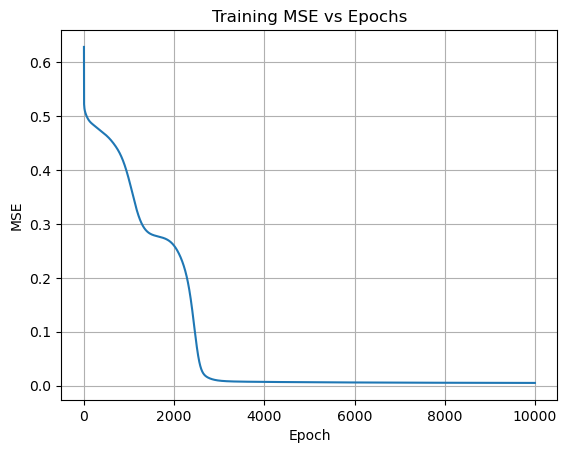

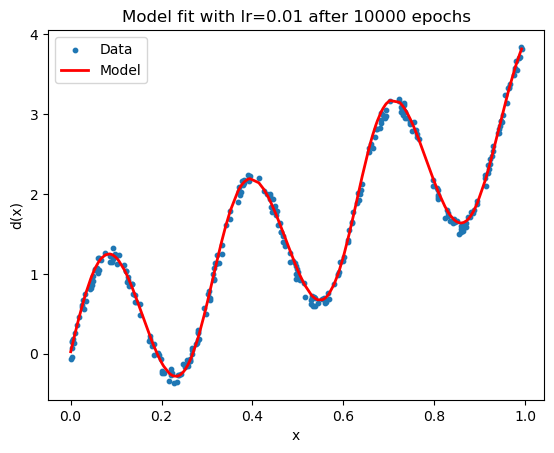

In [7]:
# Plot MSE vs epochs
plt.figure()
plt.plot(mse_history)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training MSE vs Epochs")
plt.grid(True)
plt.show()

# Plot fit curve
x_sorted = np.sort(x)
y_fit = np.array([nn.forward_single(xi) for xi in x_sorted])

plt.figure()
plt.scatter(x, d, s=10, label="Data")
plt.plot(x_sorted, y_fit, color='red', linewidth=2, label="Model")
plt.xlabel("x")
plt.ylabel("d(x)")
plt.legend()
plt.title(f"Model fit with lr={nn.learning_rate} after {len(mse_history)} epochs")
plt.show()

# 6.

Your report should include a pseudocode of your training algorithm including all gradient descent update equations written out explicitly. The pseudocode should be written in a way that anyone would be able to implement your algorithm without knowing anything about neural networks. As usual, upload a copy of your code to box with the filename 04-IDNumber-LastName.py.

- Randomly initialize $N$ hidden weights $\mathbf{w_h}$ and $N$ hidden biases $\mathbf{b_h}$
- Randomly initialize $N$ output weights $\mathbf{w_o}$ and $1$ output bias $b_o$
- $\eta \leftarrow 0.01$
- Until convergence:
  - For $epoch$ in $epoch = 1,2,3,\dots$:
    - For sample $x_i$ in $\mathbf{x}$:
      - Calculate hidden outputs $\mathbf{z}$:
        - $\mathbf{z} \leftarrow \tanh(x_i \times \mathbf{w_h} + \mathbf{b_h})$
      - Calculate output $y$:
        - $y \leftarrow \mathbf{z} \cdot \mathbf{w_o} + b_o$
      - Calculate error between output $y$ and desired output $d_i$:
        - $e_i \leftarrow d_i - y$
      - Update weights using the gradient of $e_i$:
        - Gradient wrt hidden weights: $(d_i - y) \times \mathbf{w_o} \cdot (1 - \mathbf{z}^2) \times x_i$
        - Gradient wrt hidden biases: $(d_i - y) \times \mathbf{w_o} \cdot (1 - \mathbf{z}^2)$ 
        - Gradient wrt output weights: $(d_i - y) \times \mathbf{z}$
        - Gradient wrt output bias: $(d_i - y)$
        - $\mathbf{w_h} \leftarrow \mathbf{w_h} + \eta \times \text{ gradient wrt hidden weights}$ 
        - $\mathbf{b_h} \leftarrow \mathbf{b_h} + \eta \times \text{ gradient wrt hidden biases}$
        - $\mathbf{w_o} \leftarrow \mathbf{w_o} + \eta \times \text{ gradient wrt output weights}$
        - $\mathbf{b_o} \leftarrow \mathbf{b_o} + \eta \times \text{ gradient wrt output bias}$
    - Calculate mean squared error from the errors $e_i$
    - If MSE is below some threshold, or weights and biases are no longer changing, then training is finished